In [1]:
import numpy as np
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


#bring in dipoles and energies
dipoles = np.load("LiH_r_1.4_6311g_fci_Dipoles_3.npy")
energies = np.load("LiH_r_1.4_6311g_fci_Energies_3.npy")
print(energies)
#print(dipoles)



#lambda vectors 
lambda_vec = np.array([0.0, 0.0, 0.05])




omega = 0.12086 

m_n = 0 #num_photons

mu_n = 0 #electronic state

n_elec = 50
energies = energies[:n_elec]





[-8.01219476 -7.899962   -7.88593596 -7.86104863 -7.86104863 -7.84851087
 -7.84851087 -7.80693549 -7.78459936 -7.76702524 -7.76342939 -7.75827098
 -7.75827098 -7.75123644 -7.75123644 -7.72171149 -7.68303148 -7.53167595
 -7.46183148 -7.44561152 -7.44561152 -7.44122102 -7.41700688 -7.41700688
 -7.41499491 -7.41499491 -7.40506676 -7.40302238 -7.39081209 -7.38221021
 -7.38221021 -7.37219855 -7.37219855 -7.36897222 -7.36897222 -7.35609042
 -7.35609042 -7.33714534 -7.33343267 -7.32130747 -7.31448363 -7.31448363
 -7.306799   -7.306799   -7.30583178 -7.30363511 -7.29983049 -7.29983049
 -7.29710106 -7.28736609]


In [2]:

def build_d_matrix(lambda_vec, dipoles):
    return np.einsum('k, ijk -> ij', lambda_vec, dipoles[:n_elec, : n_elec, :])
    #return np.tensordot(dipoles, lambda_vec, axes = 1)



d_matrix = build_d_matrix(lambda_vec, dipoles)

#d_matrix = d_matrix + d_matrix.T + np.diag(np.diag(d_matrix))
#d_matrix = d_matrix + d_matrix.T
print(d_matrix[0:4, 0:4])



def calc_first_order_energy_correction(d_matrix, omega, mu_n):

    E_n_1 = 0
    for gamma in range(0, len(energies)):
        E_n_1 += d_matrix[mu_n][gamma]*d_matrix[gamma][mu_n]

    E_n_1 = omega* E_n_1 

    return E_n_1                





def calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n):
    E_n_2 = 0


    for mu_l in range(0, len(energies)):
            for m_l in range(max(m_n-1,0), m_n+2):
                if(mu_l == mu_n and m_l == m_n):
                    pass
                else:

                    if m_l == m_n + 1:
                        E_n_2 +=  ( (d_matrix[mu_l][mu_n] * np.sqrt(m_n+1)) ** 2 )/(energies[mu_n] - energies[mu_l] - omega)

                        #print( d_matrix[mu_l][mu_n]  )


                    elif m_l  == m_n - 1:
                        E_n_2 +=  ( (d_matrix[mu_l][mu_n] * np.sqrt(m_n)) ** 2 )/(energies[mu_n] - energies[mu_l] + omega)

                        #print(( (d_matrix[mu_l][mu_n] * np.sqrt(m_n+1)) ** 2 )/(energies[mu_n] - energies[mu_l] - omega))

        
                    elif m_l  == m_n:

                        
                        numerator = 0
                        for gamma in range(0, len(energies)):
                            numerator += d_matrix[mu_l][gamma]*d_matrix[gamma][mu_n]

                            #print("numerator: ", numerator)


                            #print("d_matrix[mu_l][gamma]: ",  d_matrix[mu_l][gamma] ," d_matrix[gamma][mu_n]: ", d_matrix[gamma][mu_n])
                

                        E_n_2 += (numerator**2) / ((energies[mu_n] - energies[mu_l]))

                        #print("denominator:" , ((energies[mu_n] - energies[mu_l])))

                        #print("contrib: ",(numerator**2) / ((energies[mu_n] - energies[mu_l])) )



    E_n_2 = E_n_2 * omega**2
    return E_n_2




def calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2):
    return energies[mu_n] + (omega * m_n) + E_n_1 + E_n_2 

def calc_energy_correction_to_third_order(mu_n, E_n_1, E_n_2, E_n_3):
    return energies[mu_n] + (omega * m_n) + E_n_1 + E_n_2 + E_n_3



E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)



print("E_n_1: ", E_n_1)
print("E-n_2: ", E_n_2)


print("uncorrected_energy:" , energies[mu_n]+(omega * m_n))

print("energy corrected to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))

qed_fci_energies = np.load("LiH_r_1.4_6311g_qedfci_Energies.npy")
print("qed_fci_energy:", qed_fci_energies[mu_n])



[[-1.04933647e-01  2.93177629e-14 -4.50310793e-02 -3.34176204e-15]
 [ 2.93177629e-14  8.79357755e-02 -4.68065589e-14  1.04400320e-15]
 [-4.50310793e-02 -4.68065589e-14  1.04096884e-01  8.06267674e-15]
 [-3.34176204e-15  1.04400320e-15  8.06267674e-15  4.16640161e-03]]
E_n_1:  0.002139800021418779
E-n_2:  -0.0016045019835372299
uncorrected_energy: -8.012194758186697
energy corrected to second order:  -8.011659460148815
qed_fci_energy: -8.00913664849758


In [4]:

def build_d_matrix(lambda_vec, dipoles):
    return np.dot(dipoles, lambda_vec)


d_matrix = build_d_matrix(lambda_vec, dipoles)


def delta(i,j):
    if i ==j:
        return 1
    else:
        return 0



def calc_first_order_energy_correction(d_matrix, omega, mu_n):

    E_n_1 = 0
    for mu_l in range(0, len(energies)):
        E_n_1 += d_matrix[mu_n][mu_l]*d_matrix[mu_l][mu_n]

    E_n_1 = omega* E_n_1

    return E_n_1




def calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n):
    E_n_2 = 0


    for mu_l in range(0, len(energies)):

            #for m_l in range(max(m_n-1,0), m_n+2):
            for m_l in range(max(0, m_n-1), m_n+2 ):

                if(mu_l == mu_n and m_l == m_n):
                    pass
                else:

                    sum_over_energy_states_gamma = 0
                    for gamma in range(0, len(energies)):
                        #numerator += d_matrix[gamma][mu_l]*d_matrix[mu_l][gamma]
                        sum_over_energy_states_gamma += (d_matrix[mu_l][gamma]*d_matrix[gamma][mu_n] * delta(m_l, m_n))

                    
                    E_n_2 += (((-omega * d_matrix[mu_l][mu_n] * (np.sqrt(m_n +1) * delta(m_l, m_n + 1)  + np.sqrt(m_n) * delta(m_l, m_n-1)) ) + (omega * sum_over_energy_states_gamma))**2   )/ (energies[mu_n] + (m_n * omega) - energies[mu_l] - (m_l * omega))



    return E_n_2




def calc_third_order_energy_correction(d_matrix, omega, mu_n, energies, m_n):
    E_n_3 = 0

    for mu_p in range(0, len(energies)):

        for mu_q in range(0,len(energies)):
            
            for m_p in range(max(0, m_n-1), m_n+2):  

                for m_q in range(max(0,m_n-1), m_n+2):
                    
                    if((mu_p == mu_n and m_p == m_n) or (mu_q == mu_n and m_q == m_n)):
                        pass
                    else:
                        #do stuff
                        first_part_first_term = ((d_matrix[mu_n][mu_p])*(np.sqrt(m_p + 1) * delta(m_n, m_p+1) + np.sqrt(m_p) * delta(m_n, m_p-1)  ))


                        second_part_first_term = 0
                        for gamma in range(0, len(energies)):
                            second_part_first_term +=  d_matrix[mu_n][gamma]*d_matrix[gamma][mu_p] * delta(m_n, m_p)

                        first_term =  first_part_first_term - second_part_first_term


                        first_part_second_term = ((d_matrix[mu_p][mu_q])*(np.sqrt(m_q + 1) * delta(m_p, m_q+ 1) + np.sqrt(m_q) * delta(m_p, m_q-1)  ))

                        second_part_second_term = 0
                        for gamma in range(0, len(energies)):
                            second_part_second_term +=  d_matrix[mu_p][gamma]*d_matrix[gamma][mu_q]* delta(m_p, m_q)

                        second_term = first_part_second_term - second_part_second_term


                        first_part_third_term = ((d_matrix[mu_q][mu_n])*(np.sqrt(mu_n + 1) * delta(m_q, m_n+1) + np.sqrt(mu_n) * delta(m_q, m_n-1)  ))

                        second_part_third_term = 0
                        for gamma in range(0, len(energies)):
                            second_part_third_term +=  d_matrix[mu_q][gamma]*d_matrix[gamma][mu_n] * delta(m_q, m_n)
                        third_term = first_part_third_term - second_part_third_term


                        E_n_3 += (first_term*second_term*third_term) / ( ( energies[mu_n] + (m_n*omega) - energies[mu_p] - (m_p*omega)   ) *  (energies[mu_n] + (m_n*omega) - energies[mu_q] - (m_q*omega)  )   )


    E_n_3 = E_n_3 * (-omega)**3
    return E_n_3



def calc_fourth_order_energy_correction(d_matrix, omega, mu_n, energies, m_n):
    E_n_4 = 0

    for mu_p in range(0, len(energies)):

        for mu_q in range(0,len(energies)):

            for mu_r in range(0, len(energies)):
            
                for m_p in range(max(0, m_n-1), m_n+2):  

                    for m_q in range(max(0,m_n-1), m_n+2):

                        for m_r in range(max(0,m_n-1), m_n+2):
                        
                            if((mu_p == mu_n and m_p == m_n) or (mu_q == mu_n and m_q == m_n) or (mu_r == mu_n and m_r == m_n)):
                                pass
                            else:
                                #do stuff
                                first_part_first_term = ((d_matrix[mu_n][mu_p])*(np.sqrt(m_p + 1) * delta(m_n, m_p+1) + np.sqrt(m_p) * delta(m_n, m_p-1)  ))


                                second_part_first_term = 0
                                for gamma in range(0, len(energies)):
                                    second_part_first_term +=  d_matrix[mu_n][gamma]*d_matrix[gamma][mu_p] * delta(m_n, m_p)

                                first_term =  first_part_first_term - second_part_first_term


                                first_part_second_term = ((d_matrix[mu_p][mu_q])*(np.sqrt(m_q + 1) * delta(m_p, m_q+ 1) + np.sqrt(m_q) * delta(m_p, m_q-1)  ))

                                second_part_second_term = 0
                                for gamma in range(0, len(energies)):
                                    second_part_second_term +=  d_matrix[mu_p][gamma]*d_matrix[gamma][mu_q]* delta(m_p, m_q)

                                second_term = first_part_second_term - second_part_second_term


                                first_part_third_term = ((d_matrix[mu_q][mu_r])*(np.sqrt(mu_r + 1) * delta(m_q, m_r+1) + np.sqrt(mu_r) * delta(m_q, m_r-1)  ))

                                second_part_third_term = 0
                                for gamma in range(0, len(energies)):
                                    second_part_third_term +=  d_matrix[mu_q][gamma]*d_matrix[gamma][mu_r] * delta(m_q, m_r)
                                third_term = first_part_third_term - second_part_third_term


                                first_part_fourth_term = ((d_matrix[mu_r][mu_n])*(np.sqrt(mu_n + 1) * delta(m_r, m_n+1) + np.sqrt(mu_n) * delta(m_r, m_n-1)  ))

                                second_part_fourth_term = 0
                                for gamma in range(0, len(energies)):
                                    second_part_fourth_term +=  d_matrix[mu_r][gamma]*d_matrix[gamma][mu_n] * delta(m_r, m_n)
                                fourth_term = first_part_fourth_term - second_part_fourth_term


                                E_n_4 += (first_term*second_term*third_term * fourth_term) / ( ( energies[mu_n] + (m_n*omega) - energies[mu_p] - (m_p*omega)   ) *  (energies[mu_n] + (m_n*omega) - energies[mu_q] - (m_q*omega)  ) *  (energies[mu_n] + (m_n*omega) - energies[mu_r] - (m_r*omega) ))


    E_n_4 = E_n_4 * (omega)**4
    return E_n_4




def calc_energy_correction_to_first_order(mu_n, E_n_1):
    return energies[mu_n] + (omega * m_n) + E_n_1 

def calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2):
    return energies[mu_n] + (omega * m_n) + E_n_1 + E_n_2 

def calc_energy_correction_to_third_order(mu_n, E_n_1, E_n_2, E_n_3):
    return energies[mu_n] + (omega * m_n) + E_n_1 + E_n_2 + E_n_3

def calc_energy_correction_to_fourth_order(mu_n, E_n_1, E_n_2, E_n_3, E_n_4):
    return energies[mu_n] + (omega * m_n) + E_n_1 + E_n_2 + E_n_3 + E_n_4




E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


E_n_3 = calc_third_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


#E_n_4 = calc_fourth_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)




print("E_n_1: ", E_n_1)
print("E-n_2: ", E_n_2)
print("E_n_3: ", E_n_3)
#print("E_n_4: ", E_n_4)

print("uncorrected_energy:" , energies[mu_n]+(omega * m_n))

print("energy corrected to first order: " , calc_energy_correction_to_first_order(mu_n, E_n_1))
print("energy corrected to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))
print("energy corrected to third order: " , calc_energy_correction_to_third_order(mu_n, E_n_1, E_n_2, E_n_3))
#print("energy corrected to fourth order: " , calc_energy_correction_to_fourth_order(mu_n, E_n_1, E_n_2, E_n_3, E_n_4))


qed_fci_energies = np.load("LiH_r_1.4_6311g_qedfci_Energies.npy")
print("qed_fci_energy:", qed_fci_energies[mu_n])







E_n_1:  0.002139800021418779
E-n_2:  -0.00160450198353723
E_n_3:  5.6961170250172154e-05
uncorrected_energy: -8.012194758186697
energy corrected to first order:  -8.010054958165277
energy corrected to second order:  -8.011659460148815
energy corrected to third order:  -8.011602498978565
qed_fci_energy: -8.00913664849758


In [ ]:
print(E_n_1)
print(E_n_2)
print(E_n_3)

print("uncorrected_energy:" , energies[mu_n]+(omega * m_n))

print("energy corrected to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))
print("energy corrected to third order: " , calc_energy_correction_to_third_order(mu_n, E_n_1, E_n_2, E_n_3))


qed_fci_energies = np.load("LiH_r_1.4_6311g_qedfci_Energies.npy")
print("qed_fci_energy:", qed_fci_energies[mu_n])

0.0019173967282995977
-0.0015623535541212606
4.854948199159691e-05
uncorrected_energy: -8.012194758186697
energy corrected to second order:  -8.011839715012519
energy corrected to third order:  -8.011791165530527
qed_fci_energy: -8.00913664849758


In [ ]:
print("LiH full ci energy value: ",energies[0])

lambda_vec = np.array([0.0, 0.0, 0.005])
for i in range(0, 5):

    d_matrix = build_d_matrix(lambda_vec, dipoles)

    print("lambda vector: ", lambda_vec)
        
    E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


    E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


    E_n_3 = calc_third_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


    #E_n_4 = calc_fourth_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)

    print("energy corrected to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))

    print("energy corrected to third order: " , calc_energy_correction_to_third_order(mu_n, E_n_1, E_n_2, E_n_3))

    #print("energy corrected to fourth order: " , calc_energy_correction_to_fourth_order(mu_n, E_n_1, E_n_2, E_n_3, E_n_4))


    lambda_vec[2] += -0.001

LiH full ci energy value:  -8.012194758186697
lambda vector:  [0.    0.    0.005]
energy corrected to second order:  -8.012189234541081
energy corrected to third order:  -8.012189228874565
lambda vector:  [0.    0.    0.004]
energy corrected to second order:  -8.01219122265632
energy corrected to third order:  -8.012191220335358
lambda vector:  [0.    0.    0.003]
energy corrected to second order:  -8.01219276927709
energy corrected to third order:  -8.012192768542734
lambda vector:  [0.    0.    0.002]
energy corrected to second order:  -8.012193874171707
energy corrected to third order:  -8.012193874026652
lambda vector:  [0.    0.    0.001]
energy corrected to second order:  -8.012194537174674
energy corrected to third order:  -8.012194537165607


[[-1.04933647e-01  2.93177629e-14 -4.50310793e-02 -3.34176204e-15]
 [ 2.93177629e-14  8.79357755e-02 -4.68065589e-14  1.04400320e-15]
 [-4.50310793e-02 -4.68065589e-14  1.04096884e-01  8.06267674e-15]
 [-3.34176204e-15  1.04400320e-15  8.06267674e-15  4.16640161e-03]]
-0.10493364689983152
[[ 0.00000000e+00  2.93177629e-14 -4.50310793e-02 -3.34176204e-15]
 [ 2.93177629e-14  1.92869422e-01 -4.68065589e-14  1.04400320e-15]
 [-4.50310793e-02 -4.68065589e-14  2.09030531e-01  8.06267674e-15]
 [-3.34176204e-15  1.04400320e-15  8.06267674e-15  1.09100049e-01]]
[[ 0.00000000e+00  2.93177629e-14 -4.50310793e-02 -3.34176204e-15]
 [ 2.93177629e-14  1.92869422e-01 -4.68065589e-14  1.04400320e-15]
 [-4.50310793e-02 -4.68065589e-14  2.09030531e-01  8.06267674e-15]
 [-3.34176204e-15  1.04400320e-15  8.06267674e-15  1.09100049e-01]]
LiH full ci energy value:  -8.012194758186697
lambda vector:  [0.    0.    0.025]
energy to second order:  -8.012053277099113
lambda vector:  [0.    0.    0.024]
energy to 

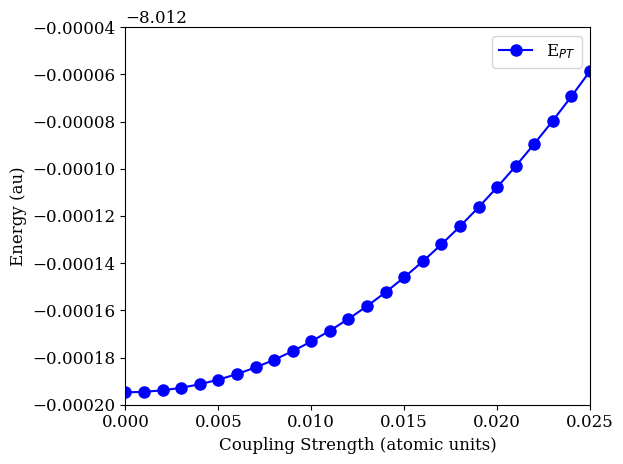

In [5]:

def build_d_matrix(lambda_vec, dipoles):
    #return np.einsum('k, ijk -> ij', lambda_vec, dipoles[:mu_n, : mu_n, :])
    #return np.einsum('k, ijk -> ij', lambda_vec, dipoles)
    return np.einsum('k, ijk -> ij', lambda_vec, dipoles[:n_elec, : n_elec, :])
    #return np.tensordot(dipoles, lambda_vec, axes = 1)

#coherent state transformation
lambda_vecs = []
energy_vals = [] 

d_matrix = build_d_matrix(lambda_vec, dipoles)


#coherent state transformation
lambda_vec = np.array([0.0, 0.0, 0.05])
#mu => (50,50,3)
#np.dot(mu[0,0,:], lambda_vec)
print(d_matrix[0:4, 0:4])
d_expectation_value = np.dot(dipoles[0,0,:], lambda_vec)
print(d_expectation_value)
#print(np.dot( d_expectation_value, np.ones((n_elec, n_elec))))

print(np.subtract(d_matrix , np.dot( d_expectation_value, np.eye(n_elec, n_elec)))[0:4, 0:4])


def coherent_state_d_matrix():
    d_matrix = np.einsum('k, ijk -> ij', lambda_vec, dipoles[:n_elec, : n_elec, :])
    d_matrix = d_matrix - np.dot(d_expectation_value, np.eye(n_elec, n_elec))
    #d_matrix = np.subtract(d_matrix , np.dot( d_expectation_value, np.ones((n_elec, n_elec))))

    return d_matrix

d_matrix = coherent_state_d_matrix()
print(d_matrix[0:4, 0:4])
print("LiH full ci energy value: ",energies[0])

lambda_vec = np.array([0.0, 0.0, 0.025])
for i in range(0, 26):

    d_matrix = build_d_matrix(lambda_vec, dipoles)
    d_matrix = coherent_state_d_matrix()
    

    print("lambda vector: ", lambda_vec)
    E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


    E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


    E_n_3 = calc_third_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


    print("energy to second order: " , calc_energy_correction_to_third_order(mu_n, E_n_1, E_n_2, E_n_3))


    lambda_vecs.append(lambda_vec[2])
    energy_vals.append(calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))
    lambda_vec[2] += -0.001

print(energy_vals)

energy_vals.reverse()
lambda_vecs.reverse()

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(lambda_vecs, energy_vals, color="blue",  marker="o", ms="8", label="E$_{PT}$")
plt.xlabel("Coupling Strength (atomic units)")
plt.ylabel("Energy (au)")
plt.xticks([0, 0.005, 0.01, 0.015, 0.020, 0.025])
plt.xlim(0, 0.025)
plt.ylim( -8.0122, -8.01204)
plt.tight_layout()
plt.legend()
plt.savefig("perturbation_theory_compare_coupling_strengths.png", dpi=150)
